In [1]:
from echelle import plot_echelle
import matplotlib.pyplot as plt
import numpy as np

from astropy.timeseries import LombScargle
from astropy.convolution import convolve, Box1DKernel
import matplotlib.pyplot as plt
import numpy as np
from lightkurve import search_lightcurve

In [6]:
def plain_echelle(f,a,ids,Dnu=6.83,obs_freqs=None,plain=True,title=None,savefilename=None):
    """
    Plots the echelle diagram for a frequency and amplitude spectrum.
    Inputs:
        f = frequency array
        a = amplitude array (same size as f, preferably smoothed)
        ids = Pandas df containing, e.g. frequencies and mode IDs.
        Dnu = 6.83 (not automatically determined)
        obs_freqs = None (for plotting observed frequencies with IDs when also plotting a full ts)
        plain = True (do not plot symbols if plain==True)
        title = None (supply a plot title)
        savefilename = None (supply a filename (incl. extension) to save plot)
    """

    norders = 15 # number of orders to plot

    fig, ax = plt.subplots(figsize=(5,6.5))
    ax2 = plot_echelle(f, a, Dnu, ax=ax, fmin=0, fmax=Dnu*(norders+1), scale='sqrt')
    ax.set_xlim(0, 1.2*Dnu)
    ax2.set_ylabel(r"Frequency (d$^{-1}$)")
    ax2.set_xlabel(r"Frequency mod $\Delta\nu$ (d$^{-1}$)")
    ax.set_ylim([0,Dnu*norders])
    plt.plot([Dnu, Dnu], [0, Dnu*norders], linestyle='dashed', color = 'blue')
    if title is not None:
        plt.title(f"{title}")

    if obs_freqs is not None:
        # obs radial modes
        add_echelle(obs_freqs.query("l_obs==0")["f_obs"],Dnu,'r','o','full',ax2,r'obs $\ell=0$')

        # obs dipole modes
        add_echelle(obs_freqs.query("l_obs==1")["f_obs"],Dnu,'r','^','full',ax2,r'obs $\ell=1$')
        
        # obs no-id modes
#         add_echelle(obs_freqs.query("l_obs==-1")["f_obs"],Dnu,'brown','x','full',ax2,r'unidentified')

    if plain==False:
        try:
            # obs radial modes
            add_echelle(ids.query("l_obs==0")["f_obs"],Dnu,'r','o','full',ax2,r'obs $\ell=0$')

            # obs dipole modes
            add_echelle(ids.query("l_obs==1")["f_obs"],Dnu,'r','^','full',ax2,r'obs $\ell=1$')
        except:
            print("could not find observed freqs")
        
        try:
            # model radial modes
            add_echelle(ids.query("l==0")["freq"],Dnu,'k','o','none',ax2,r'mdl $\ell=0$')
    
            # model dipole modes
            add_echelle(ids.query("l==1")["freq"],Dnu,'k','^','none',ax2,r'mdl $\ell=1$')
        except:
            print("could not find model freqs")

    ax2.text(Dnu, Dnu*0.8, r"$\Delta\nu={:.2f}\thinspace$ ".format(Dnu), horizontalalignment='right', color='blue')

    plt.legend(fontsize='x-small')
    
    if savefilename is not None:
        plt.savefig(f"stars/{savefilename}",bbox_inches='tight')

    plt.show()

def add_echelle(freq,Dnu,col,sym,fill,ax2,lbl=None):
    freq_x = np.mod(freq, Dnu) 
    freq_y = freq - np.mod(freq, Dnu) + Dnu/2.
    ax2.plot(freq_x, freq_y, c=col, marker=sym, linestyle='none', fillstyle=fill,label=lbl)
    ax2.plot(freq_x+Dnu, freq_y-Dnu, c=col, marker=sym, linestyle='none', fillstyle=fill)

In [3]:
def get_PDC_lightcurve(target, **kwargs):
    lc_collection = search_lightcurve(target, **kwargs).download_all()

    lc = lc_collection[0].PDCSAP_FLUX.normalize()
    for l in lc_collection[1:]:
        lc = lc.append(l.PDCSAP_FLUX.normalize())

    lc = lc.remove_nans()
    magnitude = -2.5 * np.log10(lc.flux)
    magnitude = magnitude - np.average(magnitude)
    return lc.time.value, magnitude.value


def amp_spectrum(t, y, fmin=None, fmax=None, nyq_mult=1., oversample_factor=5.):
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    
    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = (0.5 / np.median(np.diff(t)))*nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4./len(t))
    amp = np.sqrt(sc) * fct

    return freq, amp

/var/folders/fv/jm80z70j1dv7g9gj0p1qth9r0000gn/T/ipykernel_45027/2896317656.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lc_collection[0].PDCSAP_FLUX.normalize()
/var/folders/fv/jm80z70j1dv7g9gj0p1qth9r0000gn/T/ipykernel_45027/2896317656.py:6: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lc.append(l.PDCSAP_FLUX.normalize())


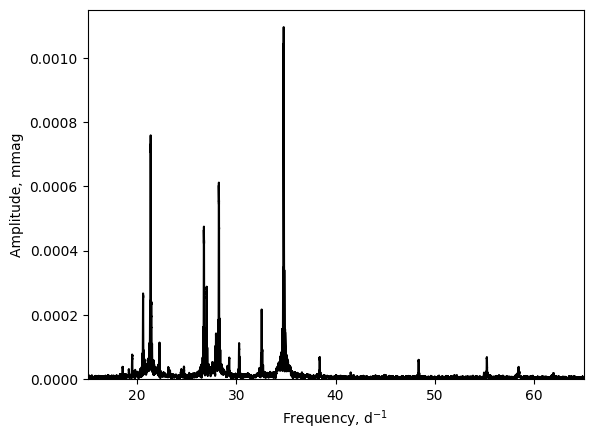

In [4]:
# t,m = get_PDC_lightcurve("HD31901",mission="TESS",cadence=120,author="SPOC")
t,m = get_PDC_lightcurve("HD139614", mission="TESS", cadence=120, author="SPOC")
# np.savetxt("stars/hd31901_lk.csv",np.array([t,m]).T)
f,a = amp_spectrum(t,m,fmax=90)
amp2 = convolve(a, Box1DKernel(20))

plt.plot(f, amp2, c='k')
plt.ylim(bottom=0)
plt.xlim(15, 65)
plt.xlabel(r"Frequency, d$^{-1}$")
plt.ylabel("Amplitude, mmag")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


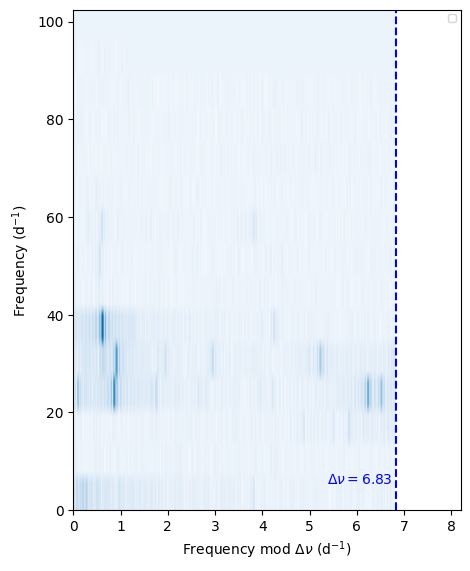

In [7]:
plain_echelle(f, a, ids=None)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

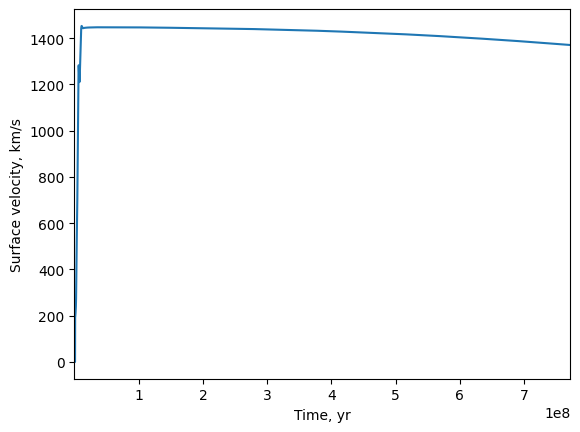

In [24]:
history = pd.read_table("work/LOGS/history_.data", skiprows=5, sep='\s+')
t = list(history['star_age'])
v_surf = list(history['surf_avg_v_rot'])

plt.plot(t, v_surf)
plt.xlabel("Time, yr")
plt.ylabel("Surface velocity, km/s")
# plt.xlim(0.1, 1e8)
plt.xlim(0.1, t[-1])
plt.show()